### Reload plots for the paper Li, Ruihe, Kirkaldy, Niall D., Oehler, Fabian, Marinescu, Monica, Offer, Gregory J., & O'Kane, Simon E. J. (2025). The importance of degradation mode analysis in parameterizing lifetime prediction models of lithium-ion battery degradation., which will be published soon on Nature Communications.  

### This notebook reproduce figures related to Experiment 2 (parameterisation)

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os; # import seaborn as sns
import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl; import json
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal

In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation",
    "Expt 2,2 - C-based Degradation 2",
    "Expt 3 - Cathode Degradation and Li-Plating",
    "Expt 4 - Drive Cycle Aging (Control)",
    "Expt 5 - Standard Cycle Aging (Control)",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [4]:
# ready experiment data
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"Reproduce_Li2024"))
sys.path.append(str_path_1) 
from Fun_NC import * # directly do this for HPC
# Load Niall's data
str_path_2 = os.path.abspath(os.path.join(pb.__path__[0],'..\\..'))
Path_NiallDMA = os.path.abspath(os.path.join(str_path_2,"SimSave\\InputData\\"))
Temp_Cell_Exp2 = Temp_Cell_Exp_All[2-1] 
Exp_2_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[2-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[2-1],
    2-1)

Finish reading Experiment!


In [5]:
import json
def Read_Model_BestFit(BasicPath,option,Scan_start,Scan_end,Pick,purpose_i,):
    purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
    path_i = os.path.join(
        BasicPath,  purpose_i,
        purpose, "Mats", f"{Pick}-StructData.json")
    # print(path_i)
    with open(path_i, 'r') as file:
        data = json.load(file)
    return data

BasicPath = os.path.join(
    os.path.abspath(os.path.join(pb.__path__[0],'..\\..')), 
    'SimSave', 'Li2024_Results', 'Save_LongRun')
option = "/" ;     
purpose_i = "SEI_Exp23_Paper_11_fine"
SEI_Exp2_GoodFit = {}
SEI_Exp2_GoodFit["10"] = Read_Model_BestFit(BasicPath,option,7,9,9,purpose_i,)
SEI_Exp2_GoodFit["25"] = Read_Model_BestFit(BasicPath,option,16,18,18,purpose_i,)
SEI_Exp2_GoodFit["40"] = Read_Model_BestFit(BasicPath,option,25,27,27,purpose_i,)

In [6]:
option = "/" ;   
purpose_i = "SEI_Dry_Exp23_Paper_11_fine"
SEIDry_Exp2_GoodFit = {}
SEIDry_Exp2_GoodFit["10"] = Read_Model_BestFit(BasicPath,option,7,9,9,purpose_i,)
SEIDry_Exp2_GoodFit["25"] = Read_Model_BestFit(BasicPath,option,16,18,18,purpose_i,)
SEIDry_Exp2_GoodFit["40"] = Read_Model_BestFit(BasicPath,option,25,27,27,purpose_i,)

In [7]:
option = "/" ;  
purpose_i = "Full_Exp23_Paper_11_fine"
Full_Exp2_GoodFit = {}
Full_Exp2_GoodFit["10"] = Read_Model_BestFit(BasicPath,option,4,6,4,purpose_i,)
Full_Exp2_GoodFit["25"] = Read_Model_BestFit(BasicPath,option,13,15,13,purpose_i,)
Full_Exp2_GoodFit["40"] = Read_Model_BestFit(BasicPath,option,22,24,22,purpose_i,)

In [8]:
SaveFig_Path = os.path.join(
    os.path.abspath(os.path.join(pb.__path__[0],'..\\..')), 
    'SimSave', 'Li2024_Results', 'SaveFig')
Target = "R_241123Exp2"
target_folder = os.path.join(SaveFig_Path, Target)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [9]:
fs=7
font = {'family' : 'Arial',  'size'   : fs}
mpl.rc('font', **font)
colors = [
    (106, 61, 154, 1),        # purple
    (230, 159, 0, 1),        # orange
    (86, 180, 233, 1),       # blue
    (213, 94, 0, 1),         # red
]
cm_4s = [(r/255, g/255, b/255, d) for r, g, b, d in colors]
ms = 4; ps_num = 20; index_exp=2;  T_deg = 25; dpi = 1000; ls = 1

In [10]:
len(Full_Exp2_GoodFit[str(T_deg)]["CD Time [h]"])

13

save figure in folder: d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2/Fig. 2 Compare voltage - 25degC.pdf


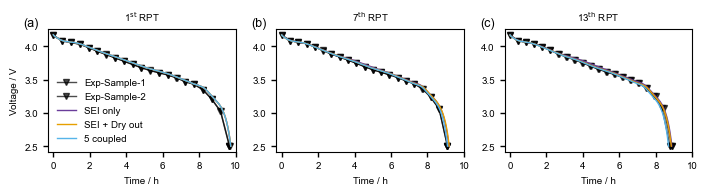

In [11]:
# Fig. 2
# 1 row * 3 columns; one T, 
def Plot_0P1C_V_3RPTs_compare_3Moldes(
    SaveFig_Path,Target,index_exp,Exp_2_AllData,
    SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit,
    T_deg,ps_num,RPT_picks,dpi,fs,SaveFig):

    target_folder = os.path.join(SaveFig_Path, Target)
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
            
    fig, axs = plt.subplots(1,3, figsize=(18/2.54,5/2.54),tight_layout=True)
    color_exp     = [0, 0, 0, 0.7]; marker_exp     = "v";
    for i,m in enumerate(RPT_picks):
        count = 0
        for cell in Temp_Cell_Exp_All[index_exp-1][str(T_deg)]:
            # plot less points
            x_data = np.array(Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
            y_data = np.array(Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
            step = len(x_data) // int(ps_num) 
            x_data_sliced = x_data[::step] + [x_data[-1]]
            y_data_sliced = y_data[::step] + [y_data[-1]]
            """ if count == 0:
                str_label = "Exp"
            else:
                str_label = None """
            str_label = f"Exp-Sample-{count+1}"
            axs[i].plot(
                x_data_sliced,y_data_sliced, color=color_exp,
                marker=marker_exp, label=str_label, linewidth=ls,
                markersize = ms )
            str_label = f"Exp-Sample-{count+1}"
            count += 1
        axs[i].plot(
            SEI_Exp2_GoodFit[str(T_deg)]["CD Time [h]"][m], 
            SEI_Exp2_GoodFit[str(T_deg)]["CD Terminal voltage [V]"][m],  
            '-', color = cm_4s[0],  
            linewidth=ls, label="SEI only") # SEIDry_Exp2_GoodFit["10"]
        axs[i].plot(
            SEIDry_Exp2_GoodFit[str(T_deg)]["CD Time [h]"][m], 
            SEIDry_Exp2_GoodFit[str(T_deg)]["CD Terminal voltage [V]"][m],     
            '-', color = cm_4s[1], 
            linewidth=ls, label="SEI + Dry out")
        axs[i].plot(
            Full_Exp2_GoodFit[str(T_deg)]["CD Time [h]"][m], 
            Full_Exp2_GoodFit[str(T_deg)]["CD Terminal voltage [V]"][m],     
            '-', color = cm_4s[2], 
            linewidth=ls, label="5 coupled")
    Titles = [
        r"1$^\mathrm{st}$ RPT",
        r"7$^\mathrm{th}$ RPT",
        r"13$^\mathrm{th}$ RPT",]
    ABC_labels = ["(a)", "(b)", "(c)"]
    for i,title in enumerate(Titles):
        axs[i].set_xlabel(r"Time / h") 
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); 
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1);del labels
        plt.subplots_adjust(top=0.4) 
        axs[i].set_title(title, fontsize = fs)
        axs[i].set_xlim(-0.3,10)
        axs[i].text(
            -0.05, 1.1, 
            ABC_labels[i], transform=axs[i].transAxes, 
            fontsize=fs+2, va='top', ha='right')
    axs[0].set_ylabel("Voltage / V")
    axs[0].legend(prop={'size':fs},loc='best',frameon=False)
    if SaveFig == True:
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.png", 
            bbox_inches='tight', dpi=dpi) 
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.svg",
            bbox_inches='tight') 
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.pdf",
            bbox_inches='tight') 
        print('save figure in folder:', target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.pdf")
        #plt.close() 
    return

RPT_picks = [0,6,12];  T_deg =10;    # m 
T_deg = 25
Plot_0P1C_V_3RPTs_compare_3Moldes(
    SaveFig_Path,Target,index_exp,Exp_2_AllData,
    SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit,
    T_deg,ps_num,RPT_picks,dpi,fs,SaveFig=True)
    

In [12]:
target_folder

'd:\\lrhwork\\model_rh\\env_pbgem_nc\\SimSave\\Li2024_Results\\SaveFig\\R_241123Exp2'

Supplementary Figure 14(b) saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2\Fig.2.xlsx
Finish save Fig. 2 and source data, to folder: d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2


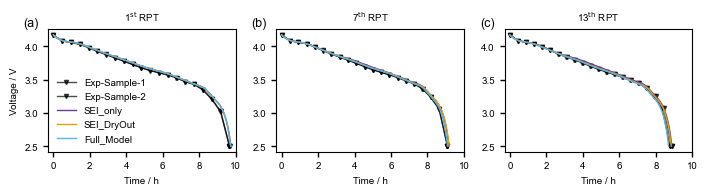

In [55]:
def Plot_0P1C_V_3RPTs_compare_3Moldes(
    SaveFig_Path, Target, index_exp, Exp_2_AllData,
    SEI_Exp2_GoodFit, SEIDry_Exp2_GoodFit, Full_Exp2_GoodFit,
    T_deg, ps_num, RPT_picks, dpi, fs, SaveFig):

    target_folder = os.path.join(SaveFig_Path, Target)
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # excel_writer = pd.ExcelWriter(
    #     os.path.join(target_folder, f"Fig.2.xlsx"), 
    #     engine='xlsxwriter'
    # )
    excel_file_path = os.path.join(target_folder, f"Fig.2.xlsx")
    data_for_excel = {}

    fig, axs = plt.subplots(1, 3, figsize=(18 / 2.54, 5 / 2.54), tight_layout=True)
    color_exp = [0, 0, 0, 0.7]
    marker_exp = "v"
    ABC_labels = ["(a)", "(b)", "(c)"]

    for i, m in enumerate(RPT_picks):
        count = 0
        dict_fig_i_ax={}

        for cell in Temp_Cell_Exp_All[index_exp - 1][str(T_deg)]:
            x_data = np.array(Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
            y_data = np.array(Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
            step = len(x_data) // int(ps_num)
            x_data_sliced = x_data[::step] + [x_data[-1]]
            y_data_sliced = y_data[::step] + [y_data[-1]]
            str_label = f"Exp-Sample-{count + 1}"
            axs[i].plot(
                x_data_sliced, y_data_sliced, color=color_exp,
                marker=marker_exp, label=str_label, linewidth=ls,
                markersize=ms)
            dict_fig_i_ax[f"Exp_Sample{count + 1}_Time_h"] = x_data_sliced
            dict_fig_i_ax[f"Exp_Sample{count + 1}_Voltage_V"] = y_data_sliced
            count += 1

        models = {
            "SEI_only": SEI_Exp2_GoodFit,
            "SEI_DryOut": SEIDry_Exp2_GoodFit,
            "Full_Model": Full_Exp2_GoodFit
        }
        for model_name, model_data in models.items():
            x_model = model_data[str(T_deg)]["CD Time [h]"][m]
            y_model = model_data[str(T_deg)]["CD Terminal voltage [V]"][m]
            axs[i].plot(
                x_model, y_model, '-', color=cm_4s[list(models.keys()).index(model_name)],
                linewidth=ls, label=model_name)
            dict_fig_i_ax[f"{model_name}_Time_h"] = x_model
            dict_fig_i_ax[f"{model_name}_Voltage_V"] = y_model

        df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
        data_for_excel[f"fig{ABC_labels[i]}"] = df_fig_i_ax

    # 设置图表标题、标签等
    Titles = [r"1$^\mathrm{st}$ RPT", r"7$^\mathrm{th}$ RPT", r"13$^\mathrm{th}$ RPT"]
    
    for i, title in enumerate(Titles):
        axs[i].set_xlabel(r"Time / h")
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1)
        axs[i].set_title(title, fontsize=fs)
        axs[i].set_xlim(-0.3, 10)
        axs[i].text(
            -0.05, 1.1, ABC_labels[i], transform=axs[i].transAxes,
            fontsize=fs + 2, va='top', ha='right'
        )
    axs[0].set_ylabel("Voltage / V")
    axs[0].legend(prop={'size': fs}, loc='best', frameon=False)

    # 保存图表和Excel文件
    if SaveFig:
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.png",
            bbox_inches='tight', dpi=dpi
        )
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.svg",
            bbox_inches='tight'
        )
        plt.savefig(
            target_folder + f"/Fig. 2 Compare voltage - {T_deg}degC.pdf",
            bbox_inches='tight'
        )
        # 保存到Excel文件
        with pd.ExcelWriter(excel_file_path) as writer:
            for sheet_name, data in data_for_excel.items():
                df = pd.DataFrame(data)
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Supplementary Figure 14(b) saved to {excel_file_path}")

    return

RPT_picks = [0,6,12];  T_deg =10;    # m 
T_deg = 25
Plot_0P1C_V_3RPTs_compare_3Moldes(
    SaveFig_Path,Target,index_exp,Exp_2_AllData,
    SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit,
    T_deg,ps_num,RPT_picks,dpi,fs,SaveFig=True)
print('Finish save Fig. 2 and source data, to folder:', target_folder)

Finish save Supplementary_Fig_1 and source data, to folder: d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2


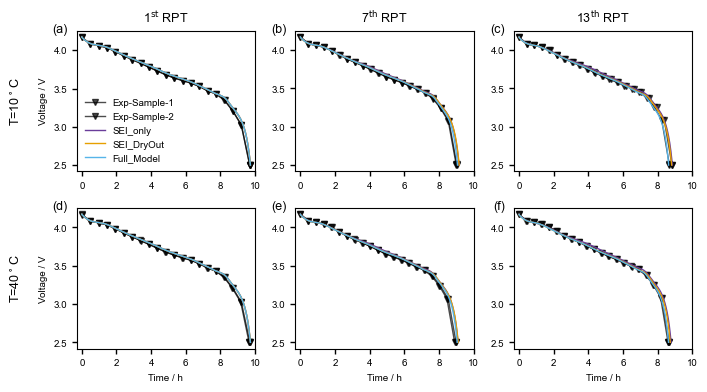

In [14]:
#Supplementary Figure 1. C/10 discharge voltage curves at 10°C (a ~ c) 
# and 40°C (d ~ f) for Experiment 2. 
# 2 row * 3 columns; [10, 40]
def Plot_0P1C_V_3RPTs_compare_3Moldes_2Ts(
    SaveFig_Path,Target,index_exp,Exp_2_AllData,
    SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit,
    T_degs,ps_num,RPT_picks,dpi,fs,SaveFig):

    target_folder = os.path.join(SaveFig_Path, Target)
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    ABC_labels = [
        "(a)", "(b)", "(c)",
        "(d)", "(e)", "(f)"]    
    excel_writer = pd.ExcelWriter(
        os.path.join(target_folder, f"Supplementary_Fig_1_Voltage_Comparison_10_40degC.xlsx"), 
        engine='xlsxwriter'
    )    
    fig, Axs = plt.subplots(
        2,3, figsize=(18/2.54,10/2.54),
        tight_layout=True)
    axs = Axs.flatten()
    color_exp     = [0, 0, 0, 0.7]; marker_exp     = "v"
    for k in range(len(T_degs)):
        for i,m in enumerate(RPT_picks):
            data_dict = {}
            count = 0
            for cell in Temp_Cell_Exp_All[index_exp-1][str(T_degs[k])]:
                # plot less points
                x_data = np.array(
                    Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]
                    ).tolist()
                y_data = np.array(
                    Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]
                    ).tolist()
                step = len(x_data) // int(ps_num) 
                x_data_sliced = x_data[::step] + [x_data[-1]]
                y_data_sliced = y_data[::step] + [y_data[-1]]
                """ if count == 0:
                    str_label = "Exp"
                else:
                    str_label = None """
                str_label = f"Exp-Sample-{count+1}"
                data_dict[f"Exp_Sample{count + 1}_Time_h"] = x_data_sliced
                data_dict[f"Exp_Sample{count + 1}_Voltage_V"] = y_data_sliced
                axs[i+k*3].plot(
                    x_data_sliced,y_data_sliced, color=color_exp,
                    marker=marker_exp, label=str_label, linewidth=ls,
                    markersize = ms )
                count += 1
            models = {
                "SEI_only": SEI_Exp2_GoodFit,
                "SEI_DryOut": SEIDry_Exp2_GoodFit,
                "Full_Model": Full_Exp2_GoodFit
            }
            for model_name, model_data in models.items():
                x_model = model_data[str(T_degs[k])]["CD Time [h]"][m]
                y_model = model_data[str(T_degs[k])]["CD Terminal voltage [V]"][m]
                data_dict[f"{model_name}_Time_h"] = x_model
                data_dict[f"{model_name}_Voltage_V"] = y_model
                axs[i+k*3].plot(
                    x_model, y_model, '-', color=cm_4s[list(models.keys()).index(model_name)],
                    linewidth=ls, label=model_name
                )
            
            labels = axs[i+k*3].get_xticklabels() + axs[i+k*3].get_yticklabels() 
            axs[i+k*3].tick_params(labelcolor='k', labelsize=fs, width=1)
            del labels
            axs[i+k*3].set_xlim(-0.3,10)
            axs[i+k*3].text(
                -0.05, 1.05, 
                ABC_labels[i+k*3], transform=axs[i+k*3].transAxes, 
                fontsize=fs+2, va='top', ha='right')
            df_rpt = pd.DataFrame.from_dict(data_dict, orient='index').T
            df_rpt.to_excel(
                excel_writer, sheet_name=f"subplot_{ABC_labels[i+k*3]}", 
                index=False)
    Titles = [
        r"1$^\mathrm{st}$ RPT",
        r"7$^\mathrm{th}$ RPT",
        r"13$^\mathrm{th}$ RPT",]
    for i,title in enumerate(Titles):
        axs[i+3].set_xlabel(r"Time / h") 
        plt.subplots_adjust(top=0.4) 
        axs[i].set_title(title, fontsize = fs+2)
        
    axs[0].set_ylabel("Voltage / V")
    axs[3].set_ylabel("Voltage / V")
    axs[0].legend(prop={'size':fs},loc='best',frameon=False)
    axs[0].text(-0.3, 0.5, "T=10"+r"$^\circ$C", 
                verticalalignment='center', 
                horizontalalignment='right', 
                rotation='vertical', 
                transform=axs[0].transAxes,
                fontsize=fs+2)
    axs[3].text(-0.3, 0.5, "T=40"+r"$^\circ$C", 
                verticalalignment='center', 
                horizontalalignment='right', 
                rotation='vertical', 
                transform=axs[3].transAxes,
                fontsize=fs+2)
    if SaveFig == True:
        plt.savefig(
            target_folder + f"/Supplementary_Fig_1_Voltage_Comparison_10_40degC.png", 
            bbox_inches='tight', dpi=dpi) 
        """ plt.savefig(
            target_folder + f"/Supplementary_Fig_1_Voltage_Comparison_10_40degC.svg",
            bbox_inches='tight') 
        plt.savefig(
            target_folder + f"/Supplementary_Fig_1_Voltage_Comparison_10_40degC.pdf",
            bbox_inches='tight')  """
        #plt.close() 
        excel_writer.close() 
    return

RPT_picks = [0,6,12]; 
T_degs = [10, 40]
Plot_0P1C_V_3RPTs_compare_3Moldes_2Ts(
    SaveFig_Path,Target,index_exp,Exp_2_AllData,
    SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit,
    T_degs,ps_num,RPT_picks,dpi,fs,SaveFig=True)
print('Finish save Supplementary_Fig_1 and source data, to folder:', target_folder)

In [15]:
def mean_percentage_error(y_true, y_pred):
    A = y_true; B =  y_pred
    if 0 in A:
        indices = np.where(A == 0)[0]
        A = np.delete(A, indices)
        B = np.delete(B, indices)
        #print(A)
    errors = np.abs(A - B) / np.abs(A)
    mpe = np.mean(errors) * 100
    return mpe
def Calculate_MPE_General(x1,x2,y1,y2):
    from scipy.interpolate import interp1d
    min_x1, max_x1 = min(x1), max(x1)
    min_x2, max_x2 = min(x2), max(x2)

    min_x = max(min_x1, min_x2)
    max_x = min(max_x1, max_x2)

    x1 = np.clip(x1, min_x, max_x)
    x2 = np.clip(x2, min_x, max_x)

    f_interp1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f_interp2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    num_points = 500  # Adjust this based on your preference
    common_x = np.linspace(min_x, max_x, num_points)

    y1_interp = f_interp1(common_x)
    y2_interp = f_interp2(common_x)

    mpe = mean_percentage_error(y1_interp, y2_interp)
    #print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    return mpe

def Calculate_0P1C_V_MPE(
        index_exp,Exp_2_AllData,
        case_i,  T_deg,m):
    Cells = Temp_Cell_Exp_All[index_exp-1][str(T_deg)]
    mpe_all = []
    for cell in Cells:
        x_true = np.array(
            Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
        y_true = np.array(
            Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
        x_model = case_i[str(T_deg)]["CD Time [h]"][m]
        y_model = case_i[str(T_deg)]["CD Terminal voltage [V]"][m]
        mpe_all .append( Calculate_MPE_General(x_true,x_model,y_true,y_model)  )
    mep_avg = sum(mpe_all) / len(mpe_all)
    return mep_avg

Cases = [SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit]; 
Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
index_exp = 2;  T_deg_All = [10,25,40] ; i_RPT=0
V_MPE_All = {}
for i,case in enumerate(Cases):
    V_MPE_All[Str_cases[i]] = {}
    for T_deg in T_deg_All:
        V_MPE_All[Str_cases[i]] [T_deg] = []

for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        for i_RPT in range(13):
            V_MPE_All[Str_cases[i]][T_deg].append(Calculate_0P1C_V_MPE(
                index_exp,Exp_2_AllData,
                Cases[i],T_deg,i_RPT)  )
i=0; T_deg=10
#print(f"{Str_cases[i]}, T={T_deg}degC")
#plt.plot( V_MPE_All[Str_cases[i]][T_deg])
""" fig, axs = plt.subplots(
    1,3, figsize=(18/2.54,5/2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
    )
ABC_labels = ["(a)", "(b)", "(c)"]
for i_ax,T_deg in enumerate(T_deg_All):
    for j in range(len(Str_cases)):
        axs[i_ax].plot(V_MPE_All[Str_cases[j]][T_deg],  
            '-', color=cm_4s[j],  
            linewidth=ls,
            label=Str_cases[j]) 
        axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0.2,1.3])
        axs[i_ax].set_xticks([0,3,6,9,11])
        axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C",fontsize = fs)
    if i_ax == 0:
        axs[i_ax].legend(loc='best',frameon=False)
        axs[i_ax].set_ylabel("MPE / %")
    axs[i_ax].text(
        -0.1, 1.1, 
        ABC_labels[i_ax], transform=axs[i_ax].transAxes, 
        fontsize=fs, va='top', ha='right')
plt.savefig(
    target_folder + f"/Fig. S5 (a~c) - MPE All 3Ts.png", 
    bbox_inches='tight', dpi=dpi)
plt.savefig(
    target_folder + f"/Fig. S5 (a~c) - MPE All 3Ts.pdf",
    bbox_inches='tight') """
print('Table 1 in main text:')
print()
print('Average MPEs of Exp-2:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        print(f"T={T_deg},{Str_cases[j]}:{np.mean(V_MPE_All[Str_cases[j]][T_deg]):.2f}")
print()
print('Standard deviation of MPEs of Exp-2:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        print(f"T={T_deg},{Str_cases[j]}:{np.std(V_MPE_All[Str_cases[j]][T_deg]):.2f}")


Table 1 in main text:

Average MPEs of Exp-2:
T=10,SEI only:0.72
T=25,SEI only:0.70
T=40,SEI only:0.80
T=10,SEI + Dry out:0.58
T=25,SEI + Dry out:0.58
T=40,SEI + Dry out:0.63
T=10,5 coupled:0.44
T=25,5 coupled:0.48
T=40,5 coupled:0.53

Standard deviation of MPEs of Exp-2:
T=10,SEI only:0.08
T=25,SEI only:0.08
T=40,SEI only:0.07
T=10,SEI + Dry out:0.11
T=25,SEI + Dry out:0.18
T=40,SEI + Dry out:0.18
T=10,5 coupled:0.13
T=25,5 coupled:0.18
T=40,5 coupled:0.20


In [16]:
# calculate RMSE:
def Calculate_RMSE_General(x1,x2,y1,y2):
    from scipy.interpolate import interp1d
    min_x1, max_x1 = min(x1), max(x1)
    min_x2, max_x2 = min(x2), max(x2)

    min_x = max(min_x1, min_x2)
    max_x = min(max_x1, max_x2)

    x1 = np.clip(x1, min_x, max_x)
    x2 = np.clip(x2, min_x, max_x)

    f_interp1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f_interp2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    num_points = 500  # Adjust this based on your preference
    common_x = np.linspace(min_x, max_x, num_points)

    y1_interp = f_interp1(common_x)
    y2_interp = f_interp2(common_x)

    RMSE =  np.sqrt(np.mean((y1_interp - y2_interp)**2)) 
    #print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    return RMSE

def Calculate_0P1C_V_RMSE(
        index_exp,Exp_2_AllData,
        case_i,  T_deg,m):
    Cells = Temp_Cell_Exp_All[index_exp-1][str(T_deg)]
    rmse_all = []
    for cell in Cells:
        x_true = np.array(
            Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
        y_true = np.array(
            Exp_2_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
        x_model = case_i[str(T_deg)]["CD Time [h]"][m]
        y_model = case_i[str(T_deg)]["CD Terminal voltage [V]"][m]
        rmse_all .append( Calculate_RMSE_General(x_true,x_model,y_true,y_model)  )
    rmse_avg = sum(rmse_all) / len(rmse_all)
    return rmse_avg

V_RMSE_All = {}
for i,case in enumerate(Cases):
    V_RMSE_All[Str_cases[i]] = {}
    for T_deg in T_deg_All:
        V_RMSE_All[Str_cases[i]] [T_deg] = []

for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        for i_RPT in range(13):
            V_RMSE_All[Str_cases[i]][T_deg].append(Calculate_0P1C_V_RMSE(
                index_exp,Exp_2_AllData,
                Cases[i],T_deg,i_RPT)  )
i=0; T_deg=10
#print(f"{Str_cases[i]}, T={T_deg}degC")
#plt.plot( V_RMSE_All[Str_cases[i]][T_deg])
""" fig, axs = plt.subplots(
    1,3, figsize=(18/2.54,5/2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
    )
ABC_labels = ["(a)", "(b)", "(c)"]
for i_ax,T_deg in enumerate(T_deg_All):
    for j in range(len(Str_cases)):
        axs[i_ax].plot(    np.array(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3,  
            '-', color=cm_4s[j],  
            #linestyle=LS[0],
            label=Str_cases[j]) 
        axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0,55])
        axs[i_ax].set_xticks([0,3,6,9,11])
        axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C", fontsize = fs)
    if i_ax == 0:
        axs[i_ax].legend(prop={'size':fs-2},loc='best',frameon=False)
        axs[i_ax].set_ylabel("RMSE / mV") """
""" plt.savefig(target_folder + f"/Fig. S5 (d~f) - RMSE All 3Ts.png",
            bbox_inches='tight', dpi=dpi)
plt.savefig(target_folder + f"/Fig. S5 (d~f) - RMSE All 3Ts.pdf",
            bbox_inches='tight') """
print('Table S9 in SI:')
print()
print('Average RMSEs of Exp-2:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        rmse_i = np.mean(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        print(f"T={T_deg},{Str_cases[j]}:{rmse_i:.2f}")

print()
print('Standard deviation of RMSEs of Exp-2:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        std_i = np.std(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        print(f"T={T_deg},{Str_cases[j]}:{std_i:.2f}")


Table S9 in SI:

Average RMSEs of Exp-2:
T=10,SEI only:34.91
T=25,SEI only:31.42
T=40,SEI only:39.39
T=10,SEI + Dry out:32.40
T=25,SEI + Dry out:29.26
T=40,SEI + Dry out:35.18
T=10,5 coupled:23.29
T=25,5 coupled:25.31
T=40,5 coupled:28.45

Standard deviation of RMSEs of Exp-2:
T=10,SEI only:5.35
T=25,SEI only:4.16
T=40,SEI only:4.42
T=10,SEI + Dry out:5.23
T=25,SEI + Dry out:8.51
T=40,SEI + Dry out:9.72
T=10,5 coupled:7.10
T=25,5 coupled:9.75
T=40,5 coupled:10.17


Supplementary Figure 2 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2\Supplementary Figure 2.xlsx


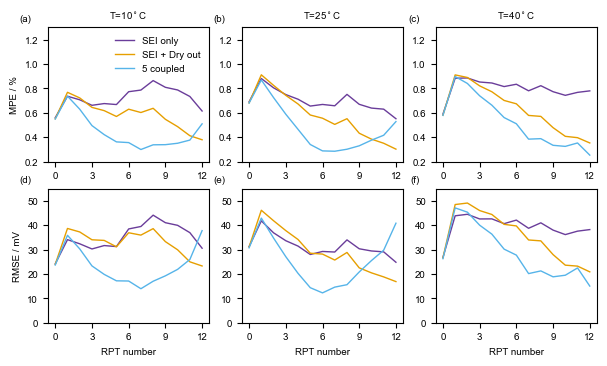

In [56]:
# Plot and save MPE and RMSE for all temperatures
fig, Axs = plt.subplots(
    2, 3, figsize=(18 / 2.54, 10 / 2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
)
axs = Axs.flatten()
ABC_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

# Initialize Excel writer for saving source data
excel_file_path = os.path.join(target_folder, f"Supplementary Figure 2.xlsx")
data_for_excel = {}

# Loop through each temperature to plot and save data
for i_ax, T_deg in enumerate(T_deg_All):
    # Initialize dictionary to store MPE and RMSE data
    dict_fig_i_ax = {}

    # Plot MPE data
    for j in range(len(Str_cases)):
        mpe_data = V_MPE_All[Str_cases[j]][T_deg]
        axs[i_ax].plot(
            mpe_data, '-', color=cm_4s[j], linewidth=ls, label=Str_cases[j]
        )
        # Save MPE data to dictionary
        dict_fig_i_ax[f"{Str_cases[j]}_MPE_%"] = mpe_data

    # Set plot properties for MPE
    axs[i_ax].set_ylim([0.2, 1.3])
    axs[i_ax].set_xticks([0, 3, 6, 9, 12])
    axs[i_ax].set_title(f"T={T_deg}" + r"$^\circ$C", fontsize=fs)
    if i_ax == 0:
        axs[i_ax].legend(loc='best', frameon=False)
        axs[i_ax].set_ylabel("MPE / %")
    axs[i_ax].text(
        -0.1, 1.1, ABC_labels[i_ax], transform=axs[i_ax].transAxes,
        fontsize=fs, va='top', ha='right')

    # Save MPE data to Excel
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig{ABC_labels[i_ax]}"] = df_fig_i_ax

    # Plot RMSE data
    i_ax_rmse = i_ax + 3
    dict_fig_i_ax = {}
    for j in range(len(Str_cases)):
        rmse_data = np.array(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        axs[i_ax_rmse].plot(
            rmse_data, '-', color=cm_4s[j], linewidth=ls, label=Str_cases[j]
        )
        # Save RMSE data to dictionary
        dict_fig_i_ax[f"{Str_cases[j]}_RMSE_mV"] = rmse_data

    # Set plot properties for RMSE
    axs[i_ax_rmse].set_xlabel(r"RPT number")
    axs[i_ax_rmse].set_ylim([0, 55])
    axs[i_ax_rmse].set_xticks([0, 3, 6, 9, 12])
    if i_ax_rmse == 3:
        axs[i_ax_rmse].set_ylabel("RMSE / mV")
    axs[i_ax_rmse].text(
        -0.1, 1.1, ABC_labels[i_ax_rmse], transform=axs[i_ax_rmse].transAxes,
        fontsize=fs, va='top', ha='right'
    )

    # Save RMSE data to Excel
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig{ABC_labels[i_ax_rmse]}"] = df_fig_i_ax

# Save figures and Excel file
plt.savefig(
    target_folder + "/Supplementary_Fig_2 (a~f) - MPE and RMSE for All 3Ts.png",
    bbox_inches='tight', dpi=dpi
)
plt.savefig(
    target_folder + "/Supplementary_Fig_2 (a~f) - MPE and RMSE for All 3Ts.pdf",
    bbox_inches='tight'
)
# 保存到Excel文件
with pd.ExcelWriter(excel_file_path) as writer:
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Supplementary Figure 2 saved to {excel_file_path}")

In [18]:
sum(SEIDry_Exp2_GoodFit[str(T_deg)]["CDend Porosity"][-1][0:10])

1.9632185105971283

In [19]:
ms = 3

Supplementary Figure 3 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2\Fig.3.xlsx


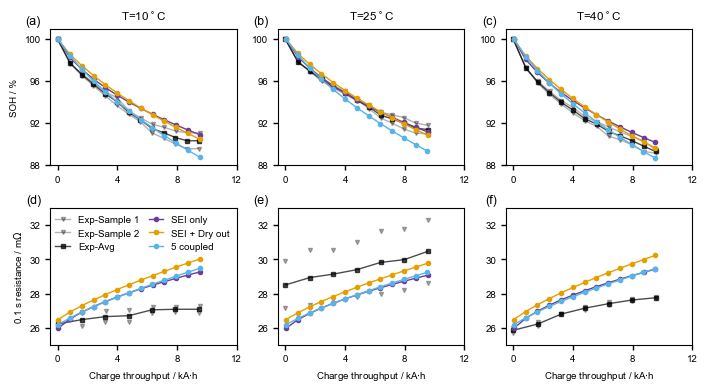

In [58]:
# Plot and validate SOH and lump resistance for 3 temperatures and 3 models
color_exp = [0, 0, 0, 0.3]; marker_exp = "v"
color_exp_Avg = [0, 0, 0, 0.7]; marker_exp_Avg = "s"
index_exp = 2; Exp_Any_AllData = Exp_2_AllData
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp - 1]

# Initialize Excel writer for saving source data
excel_file_path = os.path.join(target_folder, f"Fig.3.xlsx")
data_for_excel = {}

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18 / 2.54, 10 / 2.54), tight_layout=True)
# Add subplot labels
ABC_labels = [f"({chr(97 + i)})" for i in range(6)]

# Loop through each temperature to plot and save data
for j, T_deg in enumerate([10, 25, 40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData, Exp_temp_i_cell)
    [X_1_st, X_5_st, Y_1_st_avg, Y_2_st_avg,
     Y_3_st_avg, Y_4_st_avg, Y_5_st_avg, Y_6_st_avg] = XY_pack

    # Initialize dictionary to store SOH data
    dict_fig_i_ax = {}

    # Plot SOH data for each cell
    for m, cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"]) / 1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]

        # Save SOH data to dictionary
        dict_fig_i_ax[f"Exp_Sample{m + 1}_ChargeThroughput_kAh"] = chThr_temp
        dict_fig_i_ax[f"Exp_Sample{m + 1}_SOH_%"] = np.array(df_DMA["SoH"]) * 100

        # Plot SOH data
        axs[0, j].plot(
            chThr_temp, np.array(df_DMA["SoH"]) * 100,
            color=color_exp, marker=marker_exp, linewidth=ls,
            markersize=ms, label=f"Exp-Sample {m + 1}"
        )

    # Plot average SOH data
    axs[0, j].plot(
        X_1_st, Y_1_st_avg, color=color_exp_Avg,
        linewidth=ls, markersize=ms,
        marker=marker_exp_Avg, label="Exp-Avg")
    dict_fig_i_ax[f"Exp_avg_ChargeThroughput_kAh"] = X_1_st
    dict_fig_i_ax[f"Exp_avg_SOH_%"] = Y_1_st_avg

    # Plot model SOH data
    for k, case in enumerate(Cases):
        axs[0, j].plot(
            case[str(T_deg)]['Throughput capacity [kA.h]'],
            case[str(T_deg)]['CDend SOH [%]'],
            linewidth=ls, marker='o', markersize=ms,
            color=cm_4s[k], label=Str_cases[k]
        )
        # Save model SOH data to dictionary
        dict_fig_i_ax[f"{Str_cases[k]}_ChargeThroughput_kAh"] = case[str(T_deg)]['Throughput capacity [kA.h]']
        dict_fig_i_ax[f"{Str_cases[k]}_SOH_%"] = case[str(T_deg)]['CDend SOH [%]']

    # Set plot properties for SOH
    axs[0, j].set_ylim(88, 101)
    axs[0, j].set_xticks([0, 4, 8, 12])
    axs[0, j].set_yticks([88, 92, 96, 100])
    axs[0, j].set_title(f"T={T_deg}" + r"$^\circ$C")

    # Save SOH data to Excel
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig{ABC_labels[j]}"] = df_fig_i_ax
    
    
    # Find the maximum length of arrays
    max_length = max(
        len(np.array(Exp_Any_AllData[cell]["Extract Data"]["Charge Throughput (A.h)"]) / 1e3) for cell in Exp_temp_i_cell
    )
    dict_fig_i_ax = {}
    # Plot resistance data for each cell
    for m, cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"]) / 1e3
        res_temp = np.array(df["0.1s Resistance (Ohms)"]) * 1e3

        # Pad arrays to the maximum length
        chThr_temp_padded = np.pad(chThr_temp, (0, max_length - len(chThr_temp)), mode='constant', constant_values=np.nan)
        res_temp_padded = np.pad(res_temp, (0, max_length - len(res_temp)), mode='constant', constant_values=np.nan)

        # Save resistance data to dictionary
        dict_fig_i_ax[f"Exp_Sample{m + 1}_ChargeThroughput_kAh"] = chThr_temp_padded
        dict_fig_i_ax[f"Exp_Sample{m + 1}_Resistance_mOhm"] = res_temp_padded

        # Plot resistance data
        axs[1, j].plot(
            chThr_temp, res_temp,
            color=color_exp, marker=marker_exp,
            linewidth=ls, markersize=ms,
            label=f"Exp-Sample {m + 1}"
        )

    # Plot average resistance data
    axs[1, j].plot(
        X_5_st, Y_5_st_avg, color=color_exp_Avg,
        marker=marker_exp_Avg, label="Exp-Avg",
        linewidth=ls, markersize=ms,
    )
    dict_fig_i_ax[f"Exp_avg_ChargeThroughput_kAh"] = X_5_st
    dict_fig_i_ax[f"Exp_avg_Resistance_mOhm"] = Y_5_st_avg

    # Plot model resistance data
    for k, case in enumerate(Cases):
        axs[1, j].plot(
            case[str(T_deg)]["Throughput capacity [kA.h]"],
            np.array(case[str(T_deg)]["Res_midSOC"]),
            linewidth=ls, marker='o', markersize=ms,
            color=cm_4s[k], label=Str_cases[k]
        )
        # Save model resistance data to dictionary
        dict_fig_i_ax[f"{Str_cases[k]}_ChargeThroughput_kAh"] = case[str(T_deg)]["Throughput capacity [kA.h]"]
        dict_fig_i_ax[f"{Str_cases[k]}_Resistance_mOhm"] = np.array(case[str(T_deg)]["Res_midSOC"])

    # Set plot properties for resistance
    axs[1, j].set_xlabel(r"Charge throughput / kA$\cdot$h")
    axs[1, j].set_ylim(25, 33)
    axs[1, j].set_xticks([0, 4, 8, 12])

    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig{ABC_labels[j+3]}"] = df_fig_i_ax

# Set global plot properties
axs[0, 0].set_ylabel("SOH / %")
axs[1, 0].set_ylabel(r"0.1 s resistance / m$\Omega$")
for k in range(3):
    labels = axs[0, k].get_xticklabels() + axs[0, k].get_yticklabels()
    axs[0, k].tick_params(labelcolor='k', labelsize=fs, width=1)
    del labels
    labels = axs[1, k].get_xticklabels() + axs[1, k].get_yticklabels()
    axs[1, k].tick_params(labelcolor='k', labelsize=fs, width=1)
    del labels


axs_i = axs.flatten()
for i in range(6):
    axs_i[i].text(
        -0.05, 1.10,
        ABC_labels[i], transform=axs_i[i].transAxes,
        fontsize=fs + 2, va='top', ha='right'
    )

# Add legend
axs[1, 0].legend(
    prop={'size': fs}, loc='best', frameon=False,
    ncol=2, markerscale=1, borderpad=0.2,
    handlelength=1.5, columnspacing=1
)

# Save figures and Excel file
plt.savefig(
    target_folder + "/Fig.3 - Fit SOH and Resistance.png", dpi=dpi
)
plt.savefig(
    target_folder + "/Fig.3 - Fit SOH and Resistance.pdf"
)
# 保存到Excel文件
with pd.ExcelWriter(excel_file_path) as writer:
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Supplementary Figure 3 saved to {excel_file_path}")

In [21]:
max_length = max(
        len(np.array(Exp_Any_AllData[cell]["Extract Data"]["Charge Throughput (A.h)"]) / 1e3) for cell in Exp_temp_i_cell
    )
max_length

13

Supplementary Figure 4 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2\Fig.4.xlsx


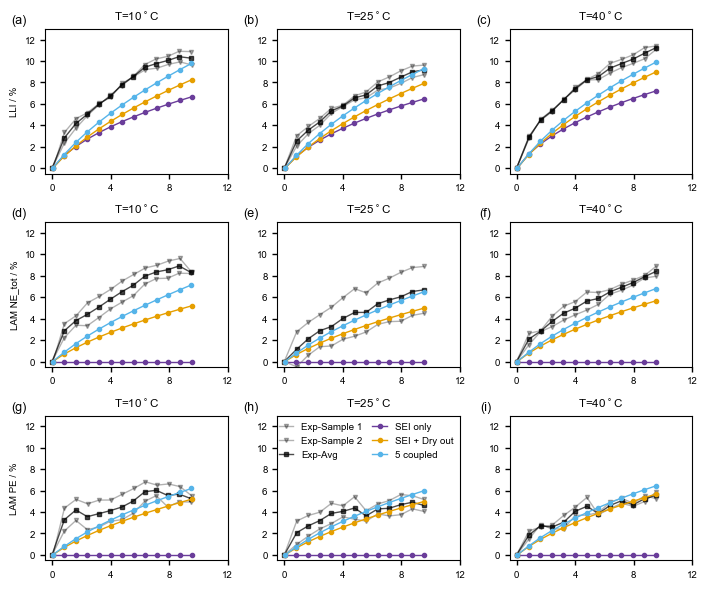

In [60]:
# Fig. 4 LLI, LAM, and LAM_PE
fig, axs = plt.subplots(3, 3, figsize=(18/2.54, 15/2.54), tight_layout=True)
excel_file_path = os.path.join(target_folder, f"Fig.4.xlsx")
data_for_excel = {}
# Add subplot labels
ABC_labels = [f"({chr(97 + i)})" for i in range(9)]
# Plotting for LLI, LAM_Ne, and LAM_Pe
count = 0
for j, metric in enumerate(['LLI', 'LAM NE_tot', 'LAM PE']):
    for i, T_deg in enumerate([10, 25, 40]):
        Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
        XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData, Exp_temp_i_cell)
        [X_1_st, X_5_st, Y_1_st_avg, Y_2_st_avg, Y_3_st_avg, Y_4_st_avg, Y_5_st_avg, Y_6_st_avg] = XY_pack

        dict_fig_i_ax={}

        # Loop for experimental data
        for m, cell in enumerate(Exp_temp_i_cell):
            df = Exp_Any_AllData[cell]["Extract Data"]
            chThr_temp = np.array(df["Charge Throughput (A.h)"]) / 1e3
            df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
            axs[j, i].plot(
                chThr_temp, np.array(df_DMA[metric]) * 100,
                color=color_exp, marker=marker_exp,
                linewidth=ls, markersize=ms,
                label=f"Exp-Sample {m + 1}")

            # Add experimental data to the DataFrame
            dict_fig_i_ax[f'Exp-Sample {m +1} - Charge Throughput (kA.h)'] = chThr_temp
            dict_fig_i_ax[f'Exp-Sample {m +1} - {metric} (%)'] = np.array(df_DMA[metric]) * 100

        # Add experimental average data
        axs[j, i].plot(
            X_1_st, [Y_2_st_avg, Y_3_st_avg, Y_4_st_avg][j],
            color=color_exp_Avg, marker=marker_exp_Avg,
            label=f"Exp-Avg", linewidth=ls, markersize=ms)

        # Add experimental average data to the DataFrame
        dict_fig_i_ax['Exp-Avg - Charge Throughput (kA.h)'] = X_1_st
        dict_fig_i_ax[f'Exp-Avg - {metric} (%)'] = [Y_2_st_avg, Y_3_st_avg, Y_4_st_avg][j]

        # Loop for model predictions
        for k, case in enumerate(Cases):
            # Use the correct keys for model predictions
            if metric == 'LLI':
                model_metric_key = 'CDend LLI [%]'
            elif metric == 'LAM NE_tot':
                model_metric_key = 'CDend LAM_ne [%]'
            elif metric == 'LAM PE':
                model_metric_key = 'CDend LAM_pe [%]'

            axs[j, i].plot(
                case[str(T_deg)]['Throughput capacity [kA.h]'],
                case[str(T_deg)][model_metric_key],
                linewidth=ls, marker='o', markersize=ms,
                color=cm_4s[k], label=Str_cases[k])

            # Add model prediction data to the DataFrame
            dict_fig_i_ax[f'{Str_cases[k]} - Charge Throughput (kA.h)'] = case[str(T_deg)]['Throughput capacity [kA.h]']
            dict_fig_i_ax[f'{Str_cases[k]} - {metric} (%)'] = case[str(T_deg)][model_metric_key]

        axs[j, i].set_ylim(-0.5, 13)
        axs[j, i].set_xticks([0, 4, 8, 12])
        axs[j, i].set_title(f"T={T_deg}" + r"$^\circ$C")

        # Store subplot data in the main dictionary
        df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
        data_for_excel[f"fig{ABC_labels[count]}"] = df_fig_i_ax
        count += 1

    axs[j, 0].set_ylabel(f"{metric} / %")
    for k in range(3):
        labels = axs[j, k].get_xticklabels() + axs[j, k].get_yticklabels()
        axs[j, k].tick_params(labelcolor='k', labelsize=fs, width=1)
        del labels


axs_i = axs.flatten()
for i in range(9):
    axs_i[i].text(
        -0.10, 1.10, ABC_labels[i], transform=axs_i[i].transAxes,
        fontsize=fs + 2, va='top', ha='right')

# Add legend
axs_i[-2].legend(
    prop={'size': fs}, loc='best', frameon=False,
    ncol=2, markerscale=1, borderpad=0.2,
    handlelength=1.5, columnspacing=1)

# Save the figure
plt.savefig(target_folder + "/Fig.4 - Fit DMA-1 of Exp-2.png", dpi=dpi)
plt.savefig(target_folder + "/Fig.4 - Fit DMA-1 of Exp-2.pdf")

# 保存到Excel文件
with pd.ExcelWriter(excel_file_path) as writer:
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Supplementary Figure 4 saved to {excel_file_path}")

" import pickle\nwith open(\n    SaveFig_Path + '/T_dependency_Exp2.pkl', 'wb') as file:\n    pickle.dump(Exp2, file) "

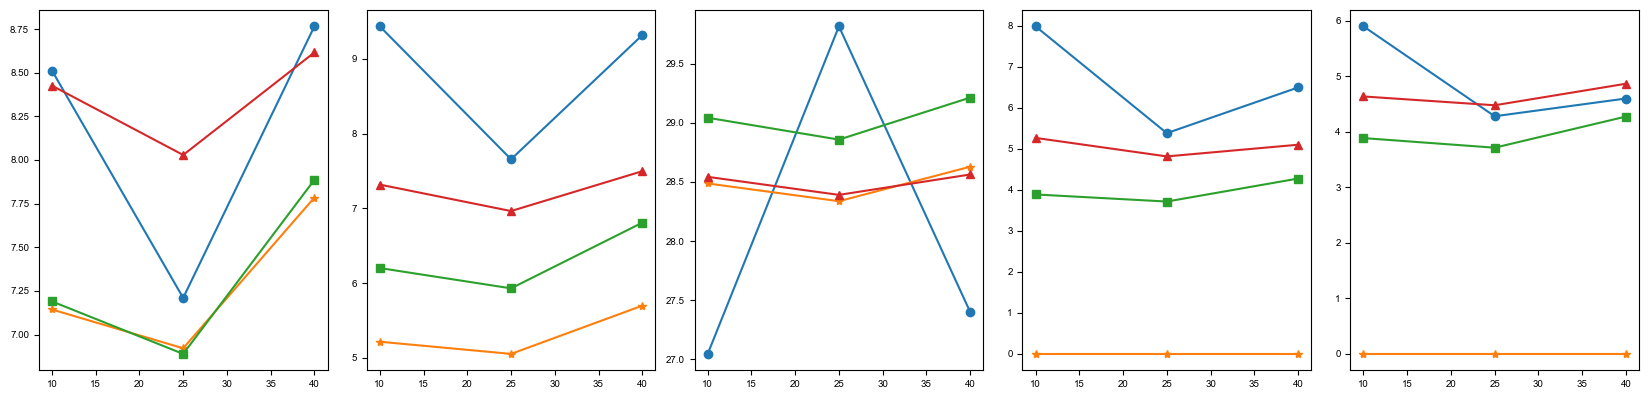

In [24]:
x_0 = 6.366576288
Exp2_exp_at_x_0 = {};            
Exp2_exp_at_x_0["x_0"] = x_0
Exp2_exp_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp2_exp_at_x_0[key] = []

Exp2_SEI_at_x_0 = {};            
Exp2_SEI_at_x_0["x_0"] = x_0
Exp2_SEI_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp2_SEI_at_x_0[key] = []

Exp2_SEIDry_at_x_0 = {};            
Exp2_SEIDry_at_x_0["x_0"] = x_0
Exp2_SEIDry_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp2_SEIDry_at_x_0[key] = []

Exp2_5couple_at_x_0 = {};            
Exp2_5couple_at_x_0["x_0"] = x_0
Exp2_5couple_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res",  "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp2_5couple_at_x_0[key] = []


for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    
    Exp2_exp_at_x_0["SOH_loss"].append(100-np.interp(x_0, X_1_st, Y_1_st_avg))
    Exp2_exp_at_x_0["LLI"].append(np.interp(x_0, X_1_st, Y_2_st_avg))
    Exp2_exp_at_x_0["Res"].append(np.interp(x_0, X_5_st, Y_5_st_avg))
    Exp2_exp_at_x_0["LAM_Ne"].append(np.interp(x_0, X_1_st, Y_3_st_avg))
    Exp2_exp_at_x_0["LAM_Pe"].append(np.interp(x_0, X_1_st, Y_4_st_avg))

    Exp2_SEI_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[0][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)]["CDend SOH [%]"])  )  )
    Exp2_SEI_at_x_0["LLI"].append(np.interp(
        x_0, Cases[0][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)]["CDend LLI [%]"])  )  )
    Exp2_SEI_at_x_0["Res"].append(np.interp(
        x_0, Cases[0][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)]["Res_midSOC"])  )  )
    Exp2_SEI_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[0][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)]["CDend LAM_ne [%]"])  )  )
    Exp2_SEI_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[0][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)]["CDend LAM_pe [%]"])  )  )

    Exp2_SEIDry_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[1][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)]["CDend SOH [%]"])  )  )
    Exp2_SEIDry_at_x_0["LLI"].append(np.interp(
        x_0, Cases[1][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)]["CDend LLI [%]"])  )  )
    Exp2_SEIDry_at_x_0["Res"].append(np.interp(
        x_0, Cases[1][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)]["Res_midSOC"])  )  )
    Exp2_SEIDry_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[1][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)]["CDend LAM_ne [%]"])  )  )
    Exp2_SEIDry_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[1][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)]["CDend LAM_pe [%]"])  )  )

    Exp2_5couple_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[2][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)]["CDend SOH [%]"])  )  )
    Exp2_5couple_at_x_0["LLI"].append(np.interp(
        x_0, Cases[2][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)]["CDend LLI [%]"])  )  )
    Exp2_5couple_at_x_0["Res"].append(np.interp(
        x_0, Cases[2][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)]["Res_midSOC"])  )  )
    Exp2_5couple_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[2][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)]["CDend LAM_ne [%]"])  )  )
    Exp2_5couple_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[2][str(T_deg)]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)]["CDend LAM_pe [%]"])  )  )
# interpretate at 6.366576288:
fig, axs = plt.subplots(1,5, figsize=(16.5,4),tight_layout=True) 
for i in range(5):
    axs[i].plot(
        Exp2_exp_at_x_0["Age_T"],Exp2_exp_at_x_0[keys[i]],"-o") 
    axs[i].plot(
        Exp2_exp_at_x_0["Age_T"],Exp2_SEI_at_x_0[keys[i]],"-*") 
    axs[i].plot(
        Exp2_exp_at_x_0["Age_T"],Exp2_SEIDry_at_x_0[keys[i]],"-s") 
    axs[i].plot(
        Exp2_exp_at_x_0["Age_T"],Exp2_5couple_at_x_0[keys[i]],"-^") 
# save
Exp2 = [
    Exp2_exp_at_x_0, Exp2_SEI_at_x_0,
    Exp2_SEIDry_at_x_0, Exp2_5couple_at_x_0
]
""" import pickle
with open(
    SaveFig_Path + '/T_dependency_Exp2.pkl', 'wb') as file:
    pickle.dump(Exp2, file) """
    

In [25]:
SaveFig_Path

'd:\\lrhwork\\model_rh\\env_pbgem_nc\\SimSave\\Li2024_Results\\SaveFig'

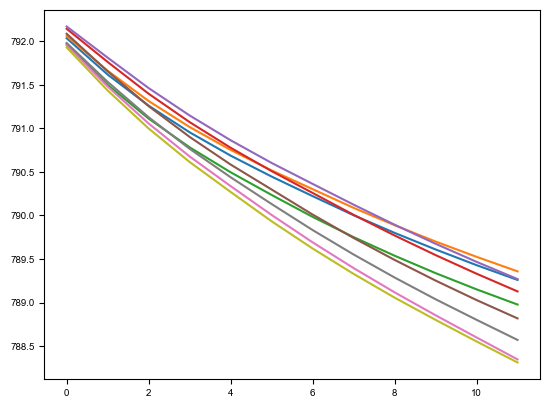

In [26]:

Cases = [SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit]; 
np.diff(Cases[0][str(40)]['Throughput capacity [kA.h]'])*1e3
for i in range(3):
    for T_deg in [10,25,40]:
        plt.plot(np.diff(Cases[i][str(T_deg)]['Throughput capacity [kA.h]'])*1e3)

In [27]:
# Get DVA 
def Get_DVA(data):
    M = len(data["CD Terminal voltage [V]"])
    data["CD Cap [A.h]"] = [];  data["CD SOC"] = [];
    data["CD dV_dQ_cell [V/Ah]"] = [];  data["CD dV_dQ_an [V/Ah]"] = [];
    data["CD dV_dQ_ca [V/Ah]"] = [];
    for m in range(M):
        V_cell = np.array(data["CD Terminal voltage [V]"][m])
        V_an   = np.array(data["CD Anode potential [V]"][m])
        V_ca   = np.array(data["CD Cathode potential [V]"][m])
        cap_dis= np.array(data["CD Time [h]"][m][-1]) * 0.5  - np.array(data["CD Time [h]"][m]) * 0.5 
        soc_dis= cap_dis / cap_dis[0] * 100
        dV_dQ_cell = np.diff(V_cell) / np.diff(cap_dis)
        dV_dQ_an = np.diff(V_an) / np.diff(cap_dis)
        dV_dQ_ca = np.diff(V_ca) / np.diff(cap_dis)
        data["CD Cap [A.h]"].append(cap_dis)
        data["CD SOC"].append(soc_dis)
        data["CD dV_dQ_cell [V/Ah]"].append(dV_dQ_cell)
        data["CD dV_dQ_an [V/Ah]"].append(dV_dQ_an)
        data["CD dV_dQ_ca [V/Ah]"].append(dV_dQ_ca)
    return data

Cases = [SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit]; 
T_deg_All = ["10","25","40"] 
for i,case_i in enumerate(Cases):
    for T_deg in T_deg_All:
        case_i[T_deg]  =  Get_DVA(case_i[T_deg])

Figure 5 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2\Fig.5.xlsx


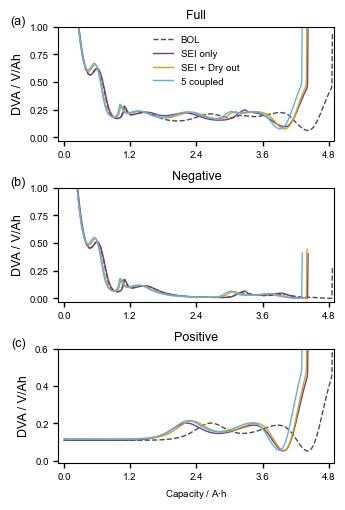

In [63]:
# Configuration parameters
T_deg = 10
m = 12
color_exp_Avg = [0, 0, 0, 0.7]
Str_cases = ["SEI only", "SEI + Dry out", "5 coupled"]
Y_V_Strs = ["CD Terminal voltage [V]", "CD Anode potential [V]", "CD Cathode potential [V]"]
Y_dV_Strs = ["CD dV_dQ_cell [V/Ah]", "CD dV_dQ_an [V/Ah]", "CD dV_dQ_ca [V/Ah]"]

# Create figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(8.8 / 2.54, 13 / 2.54), tight_layout=True)
# Add subplot labels (a), (b), (c)
ABC_labels = [f"({chr(97 + i)})" for i in range(3)]

excel_file_path = os.path.join(target_folder, f"Fig.5.xlsx")
data_for_excel = {}

# Plot data and collect for Excel
for j, y_str in enumerate(Y_dV_Strs):
    dict_fig_i_ax={}
    # Collect BOL data
    bol_cap = Cases[0][str(T_deg)]["CD Cap [A.h]"][0][0:-1]
    bol_dva = abs(Cases[0][str(T_deg)][y_str][0])
    dict_fig_i_ax[f"BOL_Cap_{y_str}"] = bol_cap
    dict_fig_i_ax[f"BOL_DVA_{y_str}"] = bol_dva
    # Plot BOL data
    axs[j].plot(bol_cap, bol_dva, linewidth=ls, linestyle='--', color=color_exp_Avg, label="BOL")

    # Collect and plot case data
    for i, case in enumerate(Cases):
        case_cap = case[str(T_deg)]["CD Cap [A.h]"][m][0:-1]
        case_dva = abs(case[str(T_deg)][y_str][m])
        dict_fig_i_ax[f"{Str_cases[i]}_Cap_{y_str}"] = case_cap
        dict_fig_i_ax[f"{Str_cases[i]}_DVA_{y_str}"] = case_dva
        # Plot case data
        axs[j].plot(case_cap, case_dva, linewidth=ls, linestyle='-', color=cm_4s[i], label=Str_cases[i])
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig{ABC_labels[j]}"] = df_fig_i_ax
    
# Set x-axis limits and ticks
for nn in range(3):
    axs[nn].set_xlim([-0.1, 4.9])
    axs[nn].set_xticks([0, 1.2, 2.4, 3.6, 4.8])

# Set y-axis labels and titles
for i, y_title in enumerate(["Full", "Negative", "Positive"]):
    axs[i].set_ylabel("DVA / V/Ah", fontsize=fs + 2)
    axs[i].set_title(y_title, fontsize=fs + 2)

# Set y-axis limits
axs[0].set_ylim([-0.03, 1.0])
axs[1].set_ylim([-0.03, 1.0])
axs[2].set_ylim([-0.01, 0.6])

# Set x-axis label
axs[2].set_xlabel(r"Capacity / A$\cdot$h")

# Format tick labels
for nn in range(3):
    labels = axs[nn].get_xticklabels() + axs[nn].get_yticklabels()
    axs[nn].tick_params(labelcolor='k', labelsize=fs, width=1)
    del labels

# Add legend
axs[0].legend(prop={'size': fs}, loc='best', frameon=False)

for i in range(3):
    axs[i].text(
        -0.12, 1.1, ABC_labels[i], transform=axs[i].transAxes, 
        fontsize=fs + 2, va='top', ha='right')

# Save the figure
plt.savefig(target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m + 1}.png", dpi=dpi)
plt.savefig(target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m + 1}.pdf")

# 保存到Excel文件
with pd.ExcelWriter(excel_file_path) as writer:
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Figure 5 saved to {excel_file_path}")


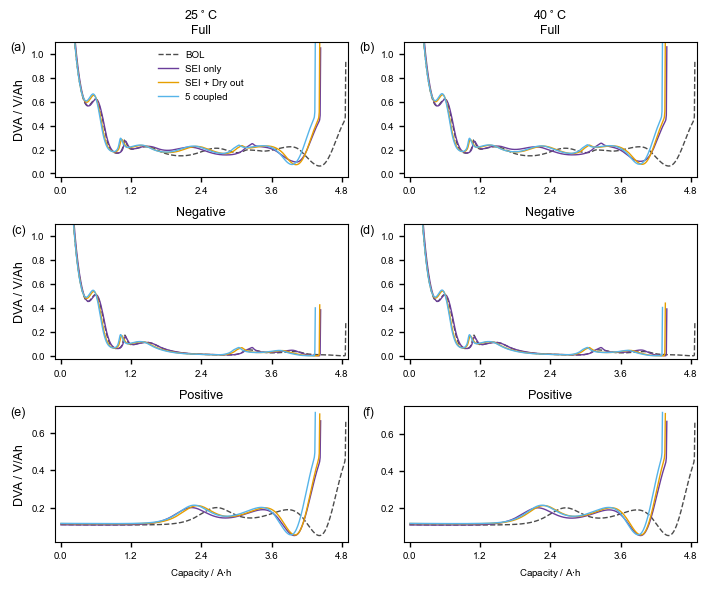

In [35]:
# Supplementary Figure 4. DVA curves of C/10 discharge for Experiment 2. 25degC and 40degC
m = 12
color_exp_Avg = [0, 0, 0, 0.7];
Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
Y_V_Strs = ["CD Terminal voltage [V]","CD Anode potential [V]", "CD Cathode potential [V]" ]
Y_dV_Strs = ["CD dV_dQ_cell [V/Ah]","CD dV_dQ_an [V/Ah]", "CD dV_dQ_ca [V/Ah]" ]
T_degs = [25, 40]
ABC_labels = [f"({chr(97+i)})" for i in range(6)]

fig, Axs = plt.subplots(3,2, figsize=(18/2.54,15/2.54),tight_layout=True)
axs = Axs.flatten()
for k in range(len(T_degs)):
    # 25degC: 0, 2, 4    2*(j+1)-2+k
    # 40degC: 1, 3, 5    2*(j+1)-1+k
    for j,y_str in enumerate(Y_dV_Strs):
        axs[2*(j+1)-2+k].plot(
            Cases[0][str(T_degs[k])]["CD Cap [A.h]"][0][0:-1], 
            abs(Cases[0][str(T_degs[k])][y_str][0]),
            linewidth=ls,  linestyle='--', 
            color = color_exp_Avg ,  label= "BOL" )
        for i,case in enumerate(Cases):
            axs[2*(j+1)-2+k].plot(
                case[str(T_degs[k])]["CD Cap [A.h]"][m][0:-1], 
                abs(case[str(T_degs[k])][y_str][m]), 
                linewidth=ls,  linestyle='-',  
                color = cm_4s[i],  label=Str_cases[i])

    for nn in range(3):
        axs[2*(nn+1)-2+k].set_xlim([-0.1,4.9])
        axs[2*(nn+1)-2+k].set_xticks([0,  1.2, 2.4, 3.6, 4.8])
    axs[k].set_title(
        f"{T_degs[k]}"+r"$^\circ$C"+"\nFull", 
        fontsize=fs+2)
    
    for nn in range(3):
        labels = axs[2*(nn+1)-2+k].get_xticklabels() + axs[2*(nn+1)-2+k].get_yticklabels()
        axs[2*(nn+1)-2+k].tick_params(
            labelcolor='k', labelsize=fs, width=1)
        del labels  

    for j in range(3):   
        axs[2*(j+1)-2+k].text(
            -0.10, 1.0, 
            ABC_labels[2*(j+1)-2+k], transform=axs[2*(j+1)-2+k].transAxes, 
            fontsize=fs+2,  # fontweight='bold', 
            va='top', ha='right')
for j in range(3): #enumerate(["Full", "Negative", "Positive"]):
    axs[2*(j+1)-2].set_ylabel('DVA / V/Ah', fontsize=fs+2)

axs[2].set_title("Negative", fontsize=fs+2)
axs[3].set_title("Negative", fontsize=fs+2)
axs[4].set_title("Positive", fontsize=fs+2)
axs[5].set_title("Positive", fontsize=fs+2)

for i in range(4):
    axs[i].set_ylim([-0.03,1.1])

axs[4].set_xlabel(r"Capacity / A$\cdot$h")
axs[5].set_xlabel(r"Capacity / A$\cdot$h")
axs[0].legend(prop={'size':fs},loc='best',frameon=False)

plt.savefig(
    target_folder + f"/Supplementary Figure 4 compare DVA-25 and 40degC - RPT {m+1}.png", 
    dpi=dpi) 
plt.savefig(
    target_folder + f"/Supplementary Figure 4 compare DVA-25 and 40degC - RPT {m+1}.svg")   

In [49]:
# Save Data for Supplementary Figure 4 to excel
data_for_excel = {}

# Collect data for Excel
for k in range(len(T_degs)):
    for j, y_str in enumerate(Y_dV_Strs):
        # Collect BOL data
        bol_cap = Cases[0][str(T_degs[k])]["CD Cap [A.h]"][0][0:-1]
        bol_dva = abs(Cases[0][str(T_degs[k])][y_str][0])
        data_for_excel[f"BOL_{T_degs[k]}degC_Cap_{y_str}"] = bol_cap
        data_for_excel[f"BOL_{T_degs[k]}degC_DVA_{y_str}"] = bol_dva

        # Collect case data
        for i, case in enumerate(Cases):
            case_cap = case[str(T_degs[k])]["CD Cap [A.h]"][m][0:-1]
            case_dva = abs(case[str(T_degs[k])][y_str][m])
            data_for_excel[f"{Str_cases[i]}_{T_degs[k]}degC_Cap_{y_str}"] = case_cap
            data_for_excel[f"{Str_cases[i]}_{T_degs[k]}degC_DVA_{y_str}"] = case_dva

# Create an Excel writer object
excel_file_path = target_folder + f"/Supplementary Figure 4 compare DVA-25 and 40degC - RPT {m+1}.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    # Save each subplot's data to a separate sheet
    for idx, label in enumerate(ABC_labels):
        # Filter data for the current subplot
        subplot_data = {
            key: value for key, value in data_for_excel.items()
            if key.endswith(Y_dV_Strs[idx % 3]) and str(T_degs[idx // 3]) in key
        }
        # Convert to DataFrame
        df = pd.DataFrame({k: pd.Series(v) for k, v in subplot_data.items()})
        # Generate sheet name using subplot label (e.g., fig(a), fig(b))
        sheet_name = f"fig({label.strip('()')})"  # Remove parentheses and add 'fig'
        # Save to a sheet
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data for Supplementary Figure 4 saved to {excel_file_path}")

Data for Supplementary Figure 4 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2/Supplementary Figure 4 compare DVA-25 and 40degC - RPT 13.xlsx


' plt.savefig(\n    target_folder + f"/Fig. S8 Full LLI break down.pdf")   '

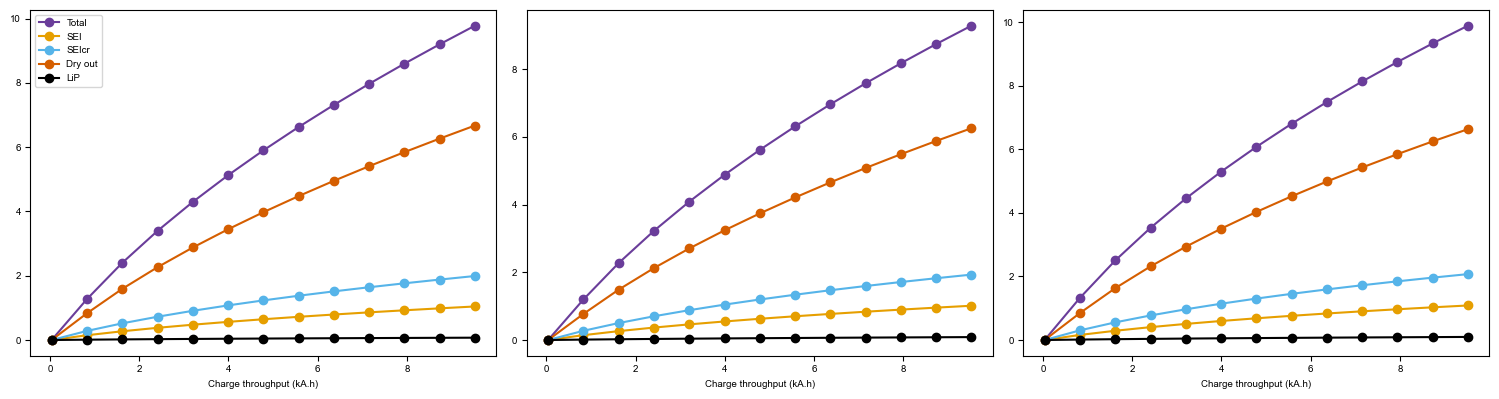

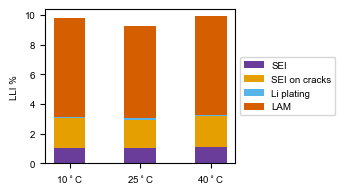

In [50]:
# - LLI  due to SEI, SEI on crack, LiP and dry-out
case = Full_Exp2_GoodFit
LLI_to_SEI_allTs=[];        LLI_to_Dry_allTs =[]; 
LLI_to_SEIcr_allTs = [];    LLI_to_LiP_allTs =[]; 
fig, axs = plt.subplots(1,3, figsize=(15,4),tight_layout=True) 
for i,T_deg in enumerate([10,25,40]):
    LLI_to_SEI = np.array(case[str(T_deg)]['CDend LLI SEI [%]'])
    LLI_to_SEIcr = np.array(case[str(T_deg)]['CDend LLI SEI on cracks [%]'])
    LLI_to_LiP = np.array(case[str(T_deg)]['CDend LLI lithium plating [%]'])
    LLI_to_Dry = (
        np.array(case[str(T_deg)]['CDend LLI [%]'])
        -LLI_to_SEI-LLI_to_LiP-LLI_to_SEIcr)
    
    LLI_to_SEI_allTs.append(LLI_to_SEI[-1])
    LLI_to_Dry_allTs.append(LLI_to_Dry[-1])
    LLI_to_SEIcr_allTs.append(LLI_to_SEIcr[-1])
    LLI_to_LiP_allTs.append(LLI_to_LiP[-1])
    axs[i].plot(
        case[str(T_deg)]['Throughput capacity [kA.h]'], 
        case[str(T_deg)]['CDend LLI [%]'], 
        '-o', color = cm_4s[0], label="Total")
    axs[i].plot(
        case[str(T_deg)]['Throughput capacity [kA.h]'], 
        LLI_to_SEI, 
        '-o', color = cm_4s[1], label="SEI")
    axs[i].plot(
        case[str(T_deg)]['Throughput capacity [kA.h]'], 
        LLI_to_SEIcr, 
        '-o', color = cm_4s[2], label="SEIcr")
    axs[i].plot(
        case[str(T_deg)]['Throughput capacity [kA.h]'], 
        LLI_to_Dry, 
        '-o', color = cm_4s[3], label="Dry out")
    axs[i].plot(
        case[str(T_deg)]['Throughput capacity [kA.h]'], 
        LLI_to_LiP, 
        '-o', color = "k", label="LiP")
    axs[i].set_xlabel("Charge throughput (kA.h)")
axs[0].legend()

# 
fig, ax = plt.subplots(figsize=(8.8/2.54, 5/2.54),tight_layout=True) 
X_labels = (
    r"10$^\circ$C",  #axs[i].set_title(f"T={T_deg}"+r"$^\circ$C")
    r"25$^\circ$C",
    r"40$^\circ$C",
)
LLI_Components = {
    "SEI":     np.array(LLI_to_SEI_allTs),
    "SEI on cracks":     np.array(LLI_to_SEIcr_allTs),
    "Li plating":     np.array(LLI_to_LiP_allTs),
    "LAM": np.array(LLI_to_Dry_allTs),
}
width = 0.45

bottom = np.zeros(3)
i=0
for key, weight_count in LLI_Components.items():
    p = ax.bar(X_labels, weight_count, width, label=key, bottom=bottom,color=cm_4s[i])
    bottom += weight_count
    i += 1

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LLI %")
""" plt.savefig(
    target_folder + f"/Fig. S8 Full LLI break down.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Fig. S8 Full LLI break down.pdf")   """

In [52]:
LAM_to_Dry   = 100-np.array(case[str(T_deg)]['Width_all'])/case[str(T_deg)]['Width_all'][0]*100
print(LAM_to_Dry)

[0.         0.00891639 0.83175767 0.91054055 1.59686968 1.66762714
 2.26733297 2.33249121 2.87076082 2.9316611  3.42326983 3.4807298
 3.935177   3.98972524 4.41355193 4.46554509 4.86349604 4.91318571
 5.28884954 5.33642177 5.69261058 5.73821197 6.07719653 6.12095071
 6.44461163]


[np.float64(0.9520514188260485), np.float64(0.5237646729033756), np.float64(0.3616159365465821)]
[np.float64(-1.2434497875801753e-14), np.float64(5.329070518200751e-15), np.float64(4.440892098500626e-15)]
[np.float64(6.199493511456012), np.float64(5.980135998958531), np.float64(6.444611631141157)]
Data saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241123Exp2/Supplementary Figure 3 Full LAM break down.xlsx


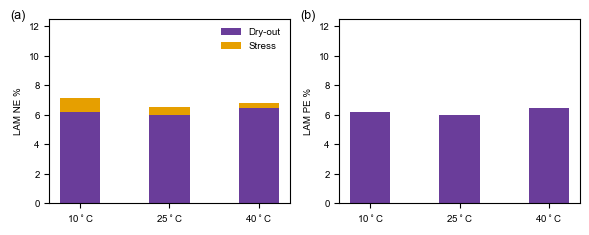

In [53]:
# Supplementary Figure 3. Different contributions to LAM in the 5 coupled model at three temperatures.
# plot break down of LAM for Full 
# LAM - due to cracking; due to dry-out
case = Full_Exp2_GoodFit
LAM_to_Crack_NE_allTs=[];        LAM_to_Dry_allTs =[];  LAM_to_Crack_PE_allTs=[];  

for i,T_deg in enumerate([10,25,40]):
    LAM_to_Dry   = 100-np.array(case[str(T_deg)]['Width_all'])/case[str(T_deg)]['Width_all'][0]*100

    LAM_to_Dry_allTs.append(LAM_to_Dry[-1])
    LAM_to_Crack_NE_allTs.append(case[str(T_deg)]['CDend LAM_ne [%]'][-1]-LAM_to_Dry[-1])
    LAM_to_Crack_PE_allTs.append(case[str(T_deg)]['CDend LAM_pe [%]'][-1]-LAM_to_Dry[-1])
print(LAM_to_Crack_NE_allTs)
print(LAM_to_Crack_PE_allTs)
print(LAM_to_Dry_allTs)
LAM_NE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_NE_allTs),}
LAM_PE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_PE_allTs),}
Labels = ["LAM NE %","LAM PE %"]
fig, axs = plt.subplots(1,2, figsize=(15/2.54 , 6/2.54),tight_layout=True) 
width = 0.45

LAM_Components_All = [LAM_NE_Components,LAM_PE_Components]
for k,LAM_Components in enumerate(LAM_Components_All):
    i=0;  bottom = np.zeros(3)
    for key, weight_count in LAM_Components.items():
        p = axs[k].bar(X_labels, weight_count, width, label=key, bottom=bottom,color=cm_4s[i])
        bottom += weight_count
        i += 1
    axs[k].set_ylim(0,12.5) # Labels
    axs[k].set_ylabel(Labels[k])
legend = axs[0].legend(loc='best',frameon=False)
axs[0].text(
    -0.1, 1.05, '(a)', transform=axs[0].transAxes, 
    fontsize=fs+2, va='top', ha='right')
axs[1].text(
    -0.1, 1.05, '(b)', transform=axs[1].transAxes, 
    fontsize=fs+2, va='top', ha='right')
plt.savefig(
    target_folder + f"/Supplementary Figure 3 Full LAM break down.png", dpi=dpi)
"""plt.savefig(
    target_folder + f"/Supplementary Figure 3 Full LAM break down.pdf")  """

# Prepare data for Excel export
data_for_excel = {
    "fig(a)": {
        "Temperature [°C]": [10, 25, 40],
        "Dry-out (NE) [%]": LAM_to_Dry_allTs,
        "Stress (NE) [%]": LAM_to_Crack_NE_allTs,
    },
    "fig(b)": {
        "Temperature [°C]": [10, 25, 40],
        "Dry-out (PE) [%]": LAM_to_Dry_allTs,
        "Stress (PE) [%]": LAM_to_Crack_PE_allTs,
    },
}

# Create an Excel writer object
excel_file_path = target_folder + "/Supplementary Figure 3 Full LAM break down.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    # Save each subplot's data to a separate sheet
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data saved to {excel_file_path}")

T=40
SEI only
[np.float64(0.8873109401067025), np.float64(3.7739449249029584), np.float64(45.866009256054014), np.float64(100.0), np.float64(100.0), np.float64(31.648649742672973)]
SEI + Dry out
[np.float64(0.885145531458034), np.float64(5.773418112744355), np.float64(37.54554399662165), np.float64(44.3504387597943), np.float64(24.447362266243353), np.float64(14.457168157654472)]
5 coupled
[np.float64(0.5868203988814195), np.float64(3.6824789401574285), np.float64(31.56538255937642), np.float64(34.162973635318956), np.float64(24.640232010849317), np.float64(12.049793592653474)]


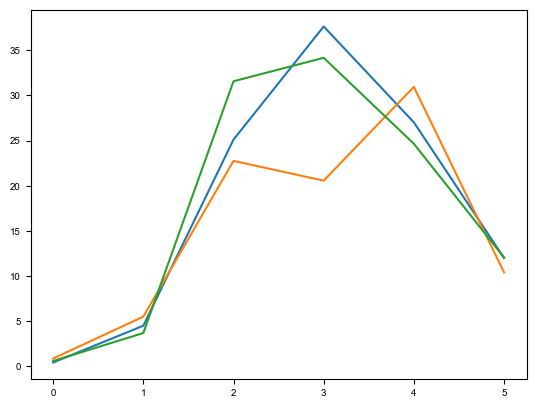

In [54]:
##### Evaluate errors:
# now compare SOH, resistance, and T rise

Cases = [SEI_Exp2_GoodFit,SEIDry_Exp2_GoodFit,Full_Exp2_GoodFit]; Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
# [0,0] --> [0]; [1,1] --> [1]; [1,2] --> [2]
# [0,1] --> [0]; [0,2] --> [1]; [1,0] --> [2]


def Calculate_MPE_re(Temp_Cell_Exp,T_deg,case_i):

    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]

    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
    # model results
    my_dict_RPT =  case_i[str(T_deg)]
    mX_1 = my_dict_RPT['Throughput capacity [kA.h]']
    if mX_1[-1] > X_1_st[-1]:
        punish = 1; 
        mX_1_st = X_1_st   # do interpolation on modelling result
        mY_1_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT['CDend SOH [%]'])
        mY_2_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LLI [%]"])
        mY_3_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LAM_ne [%]"])
        mY_4_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LAM_pe [%]"])
        mY_6_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["avg_Age_T"])
        # experiment result remain unchanged
        Y_1_st_avgm = np.array(Y_1_st_avg)
        Y_2_st_avgm = np.array(Y_2_st_avg)
        Y_3_st_avgm = np.array(Y_3_st_avg)
        Y_4_st_avgm = np.array(Y_4_st_avg)
        Y_6_st_avgm = np.array(Y_6_st_avg)
    else:                # do interpolation on expeirment results
        punish = X_1_st[-1] / mX_1[-1]  # punishment error, add when simulation end early
        mX_1_st = mX_1 #  standard for experiment following modelling
        Y_1_st_avgm = np.interp(mX_1_st,X_1_st,Y_1_st_avg)
        Y_2_st_avgm = np.interp(mX_1_st,X_1_st,Y_2_st_avg)
        Y_3_st_avgm = np.interp(mX_1_st,X_1_st,Y_3_st_avg)
        Y_4_st_avgm = np.interp(mX_1_st,X_1_st,Y_4_st_avg)
        Y_6_st_avgm = np.interp(mX_1_st,X_1_st,Y_6_st_avg)
        mY_1_st = np.array(my_dict_RPT['CDend SOH [%]'])
        mY_2_st = np.array(my_dict_RPT["CDend LLI [%]"])
        mY_3_st = np.array(my_dict_RPT["CDend LAM_ne [%]"])
        mY_4_st = np.array(my_dict_RPT["CDend LAM_pe [%]"])
        mY_6_st = np.array(my_dict_RPT["avg_Age_T"])
    if mX_1[-1] > X_5_st[-1]:
        mX_5_st = X_5_st   
        mY_5_st = np.interp(mX_5_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["Res_midSOC"])
        Y_5_st_avgm = np.array(Y_5_st_avg)
    else:
        mX_5_st = mX_1 #  standard for experiment following modelling
        mY_5_st = np.array(my_dict_RPT["Res_midSOC"])
        Y_5_st_avgm = np.interp(mX_5_st,X_5_st,Y_5_st_avg).tolist()
    # Now we can calculate MPE! mean_percentage_error
    mpe_1 = mean_percentage_error(Y_1_st_avgm, mY_1_st) # SOH [%]
    mpe_2 = mean_percentage_error(Y_2_st_avgm, mY_2_st) # LLI [%]
    mpe_3 = mean_percentage_error(Y_3_st_avgm, mY_3_st) # LAM_ne [%]
    mpe_4 = mean_percentage_error(Y_4_st_avgm, mY_4_st) # LAM_pe [%]
    mpe_5 = mean_percentage_error(Y_5_st_avgm, mY_5_st) # Res_midSOC
    mpe_6 = mean_percentage_error(Y_6_st_avgm, mY_6_st) # Age set average temperature (degC)
    # total MPE: TODO this is where weighting works
    # SOH and Resistance are directly measured so give more weight; 
    # DMA result is derived from pOCV and come with certain errors
    mpe_tot = 0.5* mpe_1 + 0.125* (mpe_2+mpe_3+mpe_4+mpe_5)
    mpe_pack = [mpe_1,mpe_5,mpe_2,mpe_3,mpe_4,mpe_tot]

    
    return mpe_pack

index_exp = 2; Exp_Any_AllData = Exp_2_AllData;  
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
T_deg_All = [10,25,40] 

MPE_All = {}
for i,case in enumerate(Cases):
    MPE_All[Str_cases[i]] = []
for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        MPE_All[Str_cases[i]].append(Calculate_MPE_re(Temp_Cell_Exp,T_deg,case))
#print(MPE_All)
i=2
plt.plot(MPE_All[Str_cases[i]][0]) # T=10
plt.plot(MPE_All[Str_cases[i]][1]) # T=25
plt.plot(MPE_All[Str_cases[i]][2]) # T=25
# for 10degC:
j = 2
print(f"T={T_deg_All[j]}")
for i in range(3):
    print(Str_cases[i])
    print(MPE_All[Str_cases[i]][j])

